<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - Previsión de demanda mediante uso de técnicas de machine learning
</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Carlos Pérez Cebrián</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Clustering

Antes de construir un modelo para la predicción de demanda vamos a analizar la existencia de patrones en los datos. Esto nos puede servir para:

1. Identificar patrones heterogéneos en los datos (estacionalidad, promociones, y características de los productos).
2. Reducir la complejidad del modelo al incluir el cluster al que pertenece cada dato como una variable categórica.
3. Mejorar la precisión del modelo.

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.


Cargamos las siguientes librerías necesarias:

In [15]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import cluster        # algoritmos de clustering.
from sklearn import datasets       
from sklearn.preprocessing import StandardScaler #estandarizar datos
from sklearn.decomposition import PCA #análisis de componentes principales, reducir dimensiones
from sklearn.neighbors import NearestNeighbors #knn
from sklearn.metrics import silhouette_score
import math

%matplotlib inline

Cargar el conjunto de datos:
(Nota: el conjunto de datos es el resultado de una fase de exploración, analisis y preparación previa.

In [8]:
# fichero con los datos de las ventas 
file_path = "Data/VentasRdo.csv"
#file_path = "Data/VentasRdo_100productos.csv"
# cargamos el .csv
df = pd.read_csv(file_path, parse_dates=['idSecuencia'])

# Mostrar las primeras filas para verificar la carga
print(df.head())

   producto idSecuencia  udsVenta  bolOpen  EnPromocion  anyomes  diasemana  \
0         1  2022-11-06       0.0        0            1        1          7   
1         2  2022-11-06       0.0        0            1        1          7   
2         3  2022-11-06       0.0        0            1        1          7   
3         4  2022-11-06       0.0        0            1        1          7   
4         5  2022-11-06       0.0        0            1        1          7   

   semana  media_7_dias  media_30_dias  venta_lag_1  venta_lag_7  venta_lag_30  
0      44           NaN            NaN          NaN          NaN           NaN  
1      44           NaN            NaN          NaN          NaN           NaN  
2      44           NaN            NaN          NaN          NaN           NaN  
3      44           NaN            NaN          NaN          NaN           NaN  
4      44           NaN            NaN          NaN          NaN           NaN  


### K-means

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es lo que popularmente se conocer como *regla del codo*.

Se basa en calcular la distancia de cada punto a su centroide asignado. Para el calculo de la distancia se toma la $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

In [9]:
#seleccionar variables
#X = df[['udsVenta', 'bolOpen', 'EnPromocion', 'diasemana', 'semana','media_7_dias','media_30_dias','venta_lag_1','venta_lag_7','venta_lag_30']]
X = df[['udsVenta', 'bolOpen', 'EnPromocion', 'diasemana', 'semana']]

print(X.isnull().sum())
#Circularidad:no incluimos estas variables que también son usadas en la predicción,
#las variables media_X_dias y ventana_lag_X contienen valores nulos.
#último valor conocido (backward-fill).
#columns_to_fill = ['media_7_dias', 'media_30_dias', 'venta_lag_1', 'venta_lag_7', 'venta_lag_30']
#X.loc[:, columns_to_fill] = X[columns_to_fill].fillna(method='ffill').fillna(method='bfill') #.loc es por un tema de índices al actualizar masivamente varias columnas

print(X.isnull().sum())

#estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

udsVenta       0
bolOpen        0
EnPromocion    0
diasemana      0
semana         0
dtype: int64
udsVenta       0
bolOpen        0
EnPromocion    0
diasemana      0
semana         0
dtype: int64


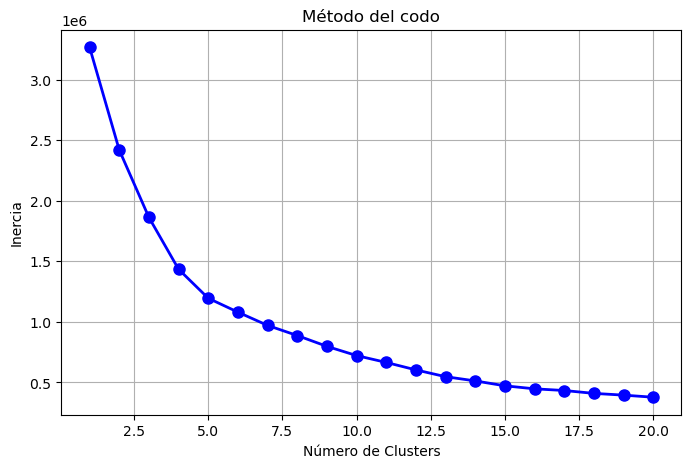

In [10]:
#método del codo
max_clusters = 20
inertia_rdo = []

for i in range(1, max_clusters + 1):
    #KMeans
    kmeans = cluster.KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(X_scaled)
    #suma de distancias cuadradas
    inertia_rdo.append((i, kmeans.inertia_))

#grafica para determinar el número óptimo de clusters
x, y = zip(*inertia_rdo)
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'bo-', markersize=8, lw=2)
plt.title('Método del codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

In [11]:
#ajustar el modelo con el número óptimo de clusters
kmeans_final = cluster.KMeans(n_clusters=4, random_state=0, n_init=10)
df['cluster'] = kmeans_final.fit_predict(X_scaled)

# Mostrar los datos con el cluster asignado
print(df)

        producto idSecuencia  udsVenta  bolOpen  EnPromocion  anyomes  \
0              1  2022-11-06  0.000000        0            1        1   
1              2  2022-11-06  0.000000        0            1        1   
2              3  2022-11-06  0.000000        0            1        1   
3              4  2022-11-06  0.000000        0            1        1   
4              5  2022-11-06  0.000000        0            1        1   
...          ...         ...       ...      ...          ...      ...   
653509       996  2024-11-05  0.000000        1            0       25   
653510       997  2024-11-05  0.000000        1            0       25   
653511       998  2024-11-05  1.098612        1            1       25   
653512       999  2024-11-05  0.000000        1            0       25   
653513      1000  2024-11-05  1.098612        1            0       25   

        diasemana  semana  media_7_dias  media_30_dias  venta_lag_1  \
0               7      44           NaN            N

In [11]:
df.to_csv("Data/VentasRdo_Cluster.csv", index=False)

Podemos determinar que el valor optimo para el valor $k$ es 5, más de 5 cluster no es significativo.

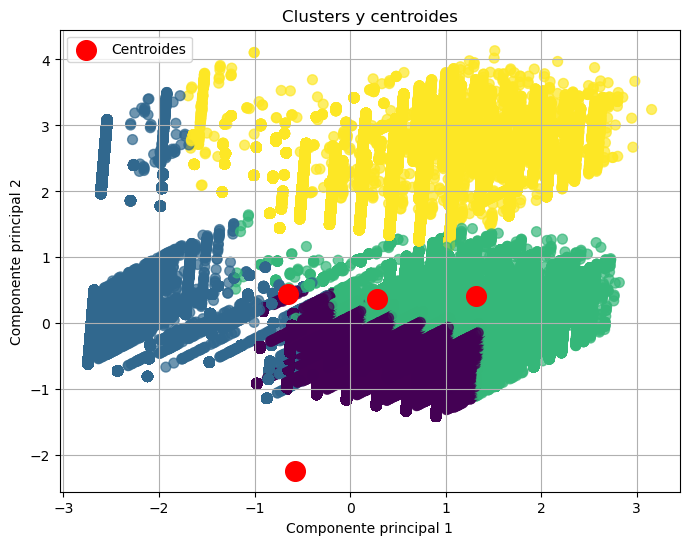

In [12]:
# Reducir las dimensiones a 2D para visualización (si tienes más de 2 variables)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los clusters en 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_final.labels_, cmap='viridis', s=50, alpha=0.7)
plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1], c='red', s=200, label='Centroides')
plt.title('Clusters y centroides')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend()
plt.grid(True)
plt.show()

La forma en la que están representados los centroides y los cluster, pueden identificar problemas de clustering o bien se trate de un problema en la representación gráfica, por lo tanto, antes de aventurarnos en determinar que hay una clara disposición de 4 cluster, vamos a evaluar la calidad de esta clusterización. Para ello, utilizamos la métrica de Silhouette, que mide la calidad del algoritmo de clustering; analiza qué tan bien separados están los clusters y qué tan bien se agrupan los puntos dentro de un mismo cluster.

In [16]:
# Calcular el Silhouette Score promedio
silhouette_avg = silhouette_score(X_scaled, kmeans_final.labels_)
print(f"Silhouette Score promedio: {silhouette_avg}")

Silhouette Score promedio: 0.3516681162329517


Tras calcular la métrica de Silhouette obtenemos un valor bajo, lo que hace confirmar que el clustering es debil y que los cluster no están claramente definidos y por tanto, no lo incluímos en nuestro conjunto de datos.

### DBSCAN

Repetimos el proceso, pero en esta ocasión utilizamos un algoritmo de clustering basado en densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) para detectar los grupos subyacentes.

In [17]:
#cargar datos
file_path = "Data/VentasRdo.csv"
file_path = "Data/VentasRdo_100productos.csv"
df_dbscan = pd.read_csv(file_path, parse_dates=['idSecuencia'])

#seleccionar variables
X = df_dbscan[['udsVenta', 'bolOpen', 'EnPromocion', 'diasemana', 'semana','media_7_dias','media_30_dias','venta_lag_1','venta_lag_7','venta_lag_30']]

#las variables media_X_dias y ventana_lag_X contienen valores nulos.
#último valor conocido (backward-fill).
columns_to_fill = ['media_7_dias', 'media_30_dias', 'venta_lag_1', 'venta_lag_7', 'venta_lag_30']
X.loc[:, columns_to_fill] = X[columns_to_fill].fillna(method='ffill').fillna(method='bfill') #.loc es por un tema de índices al actualizar masivamente varias columnas

#estandarizar los datos (DBSCAN es sensible a la escala de los datos.)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

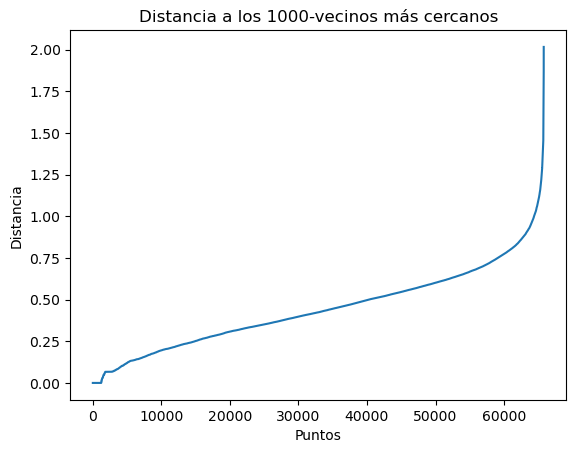

In [18]:
#para aproximar el valor de eps.
k = 1000 

#k vecinos más cercanos
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

#Ordenar las distancias
distances = np.sort(distances, axis=0)
distances = distances[:, 1]  # Usar la distancia al segundo vecino más cercano

#gráfico
i = np.arange(len(distances))

sns.lineplot(x=i, y=distances)
plt.xlabel("Puntos")
plt.ylabel("Distancia")
plt.title(f"Distancia a los {k}-vecinos más cercanos")
plt.show()

In [ ]:
distances

Buscamos la parametrización optima del algoritmo (parámetros: eps - radio máximo de vecindad, min_samples)

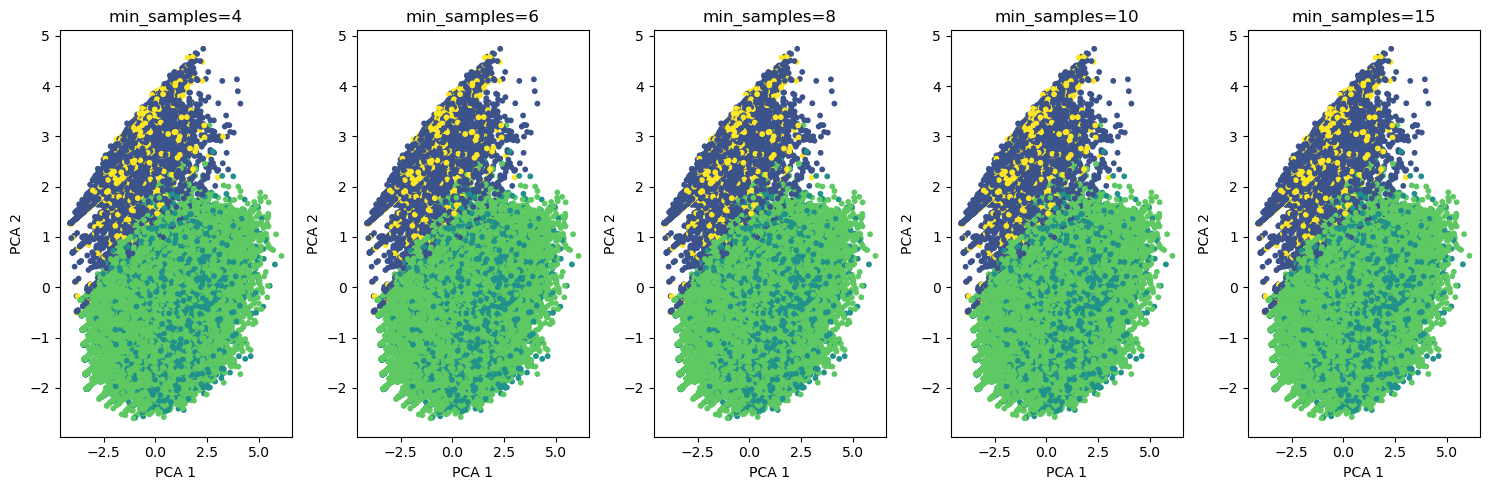

In [19]:
# min_samples (eps fijo)
X_sampled = X_scaled[:100000]

eps_final = 2.0  # Valor de eps estimado previamente
#probar para varios valores de min_samples
min_samples_values = [4, 6, 8, 10, 15]
#gráfica
fig, axes = plt.subplots(1, len(min_samples_values), figsize=(15, 5))

for idx, min_samples in enumerate(min_samples_values):
    # DBSCAN
    dbscan = cluster.DBSCAN(eps=eps_final, min_samples=min_samples)
    labels = dbscan.fit_predict(X_sampled)
    
    #Eliminar puntos de ruido (etiquetados como -1)
    X_filtered = X_sampled[labels != -1]
    labels_filtered = labels[labels != -1]
    
    # Reducir dimensionalidad para la visualización (PCA)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_filtered)
    
    # Graficar los resultados
    axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_filtered, cmap='viridis', s=10)
    axes[idx].set_title(f"min_samples={min_samples}")
    axes[idx].set_xlabel('PCA 1')
    axes[idx].set_ylabel('PCA 2')

plt.tight_layout()
plt.show()

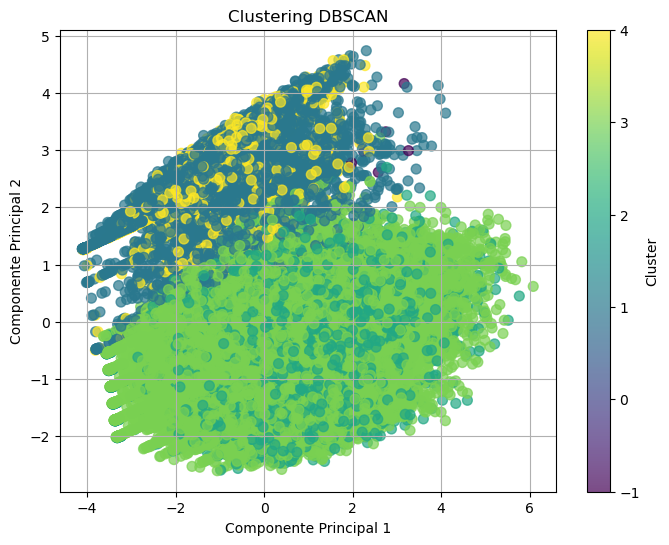

In [20]:
# 7. Visualizar los clusters en 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Reducir datos a 2 dimensiones

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Clustering DBSCAN')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()